In [1]:
import tensorflow as tf
from tensorflow.keras import Input, layers, Model
from tensorflow.keras.preprocessing.sequence import TimeseriesGenerator
import numpy as np
import geopandas as gpd
import shapely
import matplotlib.pyplot as plt

### Creating Mask

In [20]:
path = '../data/shapefile/geo_export.shp'
chicago = gpd.read_file(path)
chicago = chicago.dissolve()

xmin, ymin, xmax, ymax = chicago.total_bounds
n_x_cells = 50
x_cell_size = (xmax - xmin) / n_x_cells
n_y_cells = round(((xmax - xmin)/(ymax - ymin))*n_x_cells)
y_cell_size = (ymax - ymin) / n_y_cells
mask = np.ones((n_y_cells, n_x_cells))
x_arange = np.arange(xmin, xmax+x_cell_size, x_cell_size)
y_arange = np.arange(ymin, ymax+y_cell_size, y_cell_size)
for i, y0 in zip(range(n_y_cells-1, -1, -1), y_arange):
    for j, x0 in zip(range(n_x_cells), x_arange):
        x1 = x0-x_cell_size
        y1 = y0+y_cell_size
        box = shapely.geometry.box(x0, y0, x1, y1)
        if not chicago.intersection(box).any():
            mask[i,j] = 0
mask = tf.keras.backend.constant(mask)
mask = tf.expand_dims(mask, -1)

### Training 4 Hetero-ConvLSTMS

In [25]:
lookback = 7
batch_size = 4

train_X_crimes_only = np.load('../data/train_data.npy')
test_X_crimes_only = np.load('../data/test_data.npy')

train_X_crimes_only = tf.expand_dims(train_X_crimes_only, -1)
test_X_crimes_only = tf.expand_dims(test_X_crimes_only, -1)

train_gen = TimeseriesGenerator(
    train_X_crimes_only,
    train_X_crimes_only,
    length=lookback,
    batch_size=batch_size,
    shuffle=False
)
test_gen = TimeseriesGenerator(
    test_X_crimes_only,
    test_X_crimes_only,
    length=lookback,
    batch_size=batch_size,
    shuffle=False
)

def masked_MSE_loss(y_true, y_pred):
    y_pred_masked = tf.math.multiply(y_pred, mask)
    mse = tf.keras.losses.mean_squared_error(y_true = y_true, y_pred = y_pred_masked)
    return mse

# Define the input tensors
inputs = Input(shape=(lookback, *train_X_crimes_only.shape[1:]))

# First stack of convlstm layers
convlstm1 = layers.ConvLSTM2D(filters=128, kernel_size=(3, 3), padding='same', activation='tanh', return_sequences=True)(inputs)
bathnorm1 = layers.BatchNormalization()(convlstm1)
convlstm2 = layers.ConvLSTM2D(filters=128, kernel_size=(3, 3), padding='same', activation='tanh', return_sequences=False)(bathnorm1)

# Second stack of convlstm layers
convlstm3 = layers.ConvLSTM2D(filters=128, kernel_size=(3, 3), padding='same', activation='tanh', return_sequences=True)(inputs)
batchnorm2 = layers.BatchNormalization()(convlstm3)
convlstm4 = layers.ConvLSTM2D(filters=128, kernel_size=(3, 3), padding='same', activation='tanh', return_sequences=False)(batchnorm2)

# Concatenate outputs of two stacks
concatenation = layers.concatenate([convlstm2, convlstm4])
outputs = layers.Conv2D(filters=1, kernel_size=1, padding="same", activation='tanh')(concatenation)

# Create the model
model = Model(inputs=inputs, outputs=outputs)

# Compile the model
model.compile(optimizer='adam', loss=masked_MSE_loss, metrics=['mae'])

# Train the model
model.fit(train_gen, epochs=1)

# Create test prediction
test_pred = model.predict(test_gen)
test_pred *= mask

ResourceExhaustedError: Graph execution error:

Detected at node 'model_2/conv_lstm2d_13/while/clip_by_value_2/Minimum' defined at (most recent call last):
    File "c:\Users\lcdew\AppData\Local\Programs\Python\Python38\lib\runpy.py", line 194, in _run_module_as_main
      return _run_code(code, main_globals, None,
    File "c:\Users\lcdew\AppData\Local\Programs\Python\Python38\lib\runpy.py", line 87, in _run_code
      exec(code, run_globals)
    File "C:\Users\lcdew\AppData\Roaming\Python\Python38\site-packages\ipykernel_launcher.py", line 17, in <module>
      app.launch_new_instance()
    File "C:\Users\lcdew\AppData\Roaming\Python\Python38\site-packages\traitlets\config\application.py", line 976, in launch_instance
      app.start()
    File "C:\Users\lcdew\AppData\Roaming\Python\Python38\site-packages\ipykernel\kernelapp.py", line 712, in start
      self.io_loop.start()
    File "C:\Users\lcdew\AppData\Roaming\Python\Python38\site-packages\tornado\platform\asyncio.py", line 215, in start
      self.asyncio_loop.run_forever()
    File "c:\Users\lcdew\AppData\Local\Programs\Python\Python38\lib\asyncio\base_events.py", line 570, in run_forever
      self._run_once()
    File "c:\Users\lcdew\AppData\Local\Programs\Python\Python38\lib\asyncio\base_events.py", line 1859, in _run_once
      handle._run()
    File "c:\Users\lcdew\AppData\Local\Programs\Python\Python38\lib\asyncio\events.py", line 81, in _run
      self._context.run(self._callback, *self._args)
    File "C:\Users\lcdew\AppData\Roaming\Python\Python38\site-packages\ipykernel\kernelbase.py", line 510, in dispatch_queue
      await self.process_one()
    File "C:\Users\lcdew\AppData\Roaming\Python\Python38\site-packages\ipykernel\kernelbase.py", line 499, in process_one
      await dispatch(*args)
    File "C:\Users\lcdew\AppData\Roaming\Python\Python38\site-packages\ipykernel\kernelbase.py", line 406, in dispatch_shell
      await result
    File "C:\Users\lcdew\AppData\Roaming\Python\Python38\site-packages\ipykernel\kernelbase.py", line 730, in execute_request
      reply_content = await reply_content
    File "C:\Users\lcdew\AppData\Roaming\Python\Python38\site-packages\ipykernel\ipkernel.py", line 383, in do_execute
      res = shell.run_cell(
    File "C:\Users\lcdew\AppData\Roaming\Python\Python38\site-packages\ipykernel\zmqshell.py", line 528, in run_cell
      return super().run_cell(*args, **kwargs)
    File "C:\Users\lcdew\AppData\Roaming\Python\Python38\site-packages\IPython\core\interactiveshell.py", line 2940, in run_cell
      result = self._run_cell(
    File "C:\Users\lcdew\AppData\Roaming\Python\Python38\site-packages\IPython\core\interactiveshell.py", line 2995, in _run_cell
      return runner(coro)
    File "C:\Users\lcdew\AppData\Roaming\Python\Python38\site-packages\IPython\core\async_helpers.py", line 129, in _pseudo_sync_runner
      coro.send(None)
    File "C:\Users\lcdew\AppData\Roaming\Python\Python38\site-packages\IPython\core\interactiveshell.py", line 3194, in run_cell_async
      has_raised = await self.run_ast_nodes(code_ast.body, cell_name,
    File "C:\Users\lcdew\AppData\Roaming\Python\Python38\site-packages\IPython\core\interactiveshell.py", line 3373, in run_ast_nodes
      if await self.run_code(code, result, async_=asy):
    File "C:\Users\lcdew\AppData\Roaming\Python\Python38\site-packages\IPython\core\interactiveshell.py", line 3433, in run_code
      exec(code_obj, self.user_global_ns, self.user_ns)
    File "C:\Users\lcdew\AppData\Local\Temp\ipykernel_12728\3867184340.py", line 54, in <module>
      model.fit(train_gen, epochs=1)
    File "C:\Users\lcdew\AppData\Roaming\Python\Python38\site-packages\keras\utils\traceback_utils.py", line 65, in error_handler
      return fn(*args, **kwargs)
    File "C:\Users\lcdew\AppData\Roaming\Python\Python38\site-packages\keras\engine\training.py", line 1564, in fit
      tmp_logs = self.train_function(iterator)
    File "C:\Users\lcdew\AppData\Roaming\Python\Python38\site-packages\keras\engine\training.py", line 1160, in train_function
      return step_function(self, iterator)
    File "C:\Users\lcdew\AppData\Roaming\Python\Python38\site-packages\keras\engine\training.py", line 1146, in step_function
      outputs = model.distribute_strategy.run(run_step, args=(data,))
    File "C:\Users\lcdew\AppData\Roaming\Python\Python38\site-packages\keras\engine\training.py", line 1135, in run_step
      outputs = model.train_step(data)
    File "C:\Users\lcdew\AppData\Roaming\Python\Python38\site-packages\keras\engine\training.py", line 993, in train_step
      y_pred = self(x, training=True)
    File "C:\Users\lcdew\AppData\Roaming\Python\Python38\site-packages\keras\utils\traceback_utils.py", line 65, in error_handler
      return fn(*args, **kwargs)
    File "C:\Users\lcdew\AppData\Roaming\Python\Python38\site-packages\keras\engine\training.py", line 557, in __call__
      return super().__call__(*args, **kwargs)
    File "C:\Users\lcdew\AppData\Roaming\Python\Python38\site-packages\keras\utils\traceback_utils.py", line 65, in error_handler
      return fn(*args, **kwargs)
    File "C:\Users\lcdew\AppData\Roaming\Python\Python38\site-packages\keras\engine\base_layer.py", line 1097, in __call__
      outputs = call_fn(inputs, *args, **kwargs)
    File "C:\Users\lcdew\AppData\Roaming\Python\Python38\site-packages\keras\utils\traceback_utils.py", line 96, in error_handler
      return fn(*args, **kwargs)
    File "C:\Users\lcdew\AppData\Roaming\Python\Python38\site-packages\keras\engine\functional.py", line 510, in call
      return self._run_internal_graph(inputs, training=training, mask=mask)
    File "C:\Users\lcdew\AppData\Roaming\Python\Python38\site-packages\keras\engine\functional.py", line 667, in _run_internal_graph
      outputs = node.layer(*args, **kwargs)
    File "C:\Users\lcdew\AppData\Roaming\Python\Python38\site-packages\keras\layers\rnn\base_rnn.py", line 553, in __call__
      return super().__call__(inputs, **kwargs)
    File "C:\Users\lcdew\AppData\Roaming\Python\Python38\site-packages\keras\utils\traceback_utils.py", line 65, in error_handler
      return fn(*args, **kwargs)
    File "C:\Users\lcdew\AppData\Roaming\Python\Python38\site-packages\keras\engine\base_layer.py", line 1097, in __call__
      outputs = call_fn(inputs, *args, **kwargs)
    File "C:\Users\lcdew\AppData\Roaming\Python\Python38\site-packages\keras\utils\traceback_utils.py", line 96, in error_handler
      return fn(*args, **kwargs)
    File "C:\Users\lcdew\AppData\Roaming\Python\Python38\site-packages\keras\layers\rnn\base_conv_lstm.py", line 506, in call
      return super().call(
    File "C:\Users\lcdew\AppData\Roaming\Python\Python38\site-packages\keras\layers\rnn\base_conv_rnn.py", line 327, in call
      last_output, outputs, states = backend.rnn(
    File "C:\Users\lcdew\AppData\Roaming\Python\Python38\site-packages\keras\backend.py", line 5139, in rnn
      final_outputs = tf.compat.v1.while_loop(
    File "C:\Users\lcdew\AppData\Roaming\Python\Python38\site-packages\keras\backend.py", line 5118, in _step
      output, new_states = step_function(
    File "C:\Users\lcdew\AppData\Roaming\Python\Python38\site-packages\keras\layers\rnn\base_conv_rnn.py", line 325, in step
      return self.cell.call(inputs, states, **kwargs)
    File "C:\Users\lcdew\AppData\Roaming\Python\Python38\site-packages\keras\layers\rnn\base_conv_lstm.py", line 282, in call
      o = self.recurrent_activation(x_o + h_o)
    File "C:\Users\lcdew\AppData\Roaming\Python\Python38\site-packages\keras\activations.py", line 464, in hard_sigmoid
      return backend.hard_sigmoid(x)
    File "C:\Users\lcdew\AppData\Roaming\Python\Python38\site-packages\keras\backend.py", line 5792, in hard_sigmoid
      x = tf.clip_by_value(x, 0.0, 1.0)
Node: 'model_2/conv_lstm2d_13/while/clip_by_value_2/Minimum'
failed to allocate memory
	 [[{{node model_2/conv_lstm2d_13/while/clip_by_value_2/Minimum}}]]
Hint: If you want to see a list of allocated tensors when OOM happens, add report_tensor_allocations_upon_oom to RunOptions for current allocation info. This isn't available when running in Eager mode.
 [Op:__inference_train_function_28684]

### Plotting Results

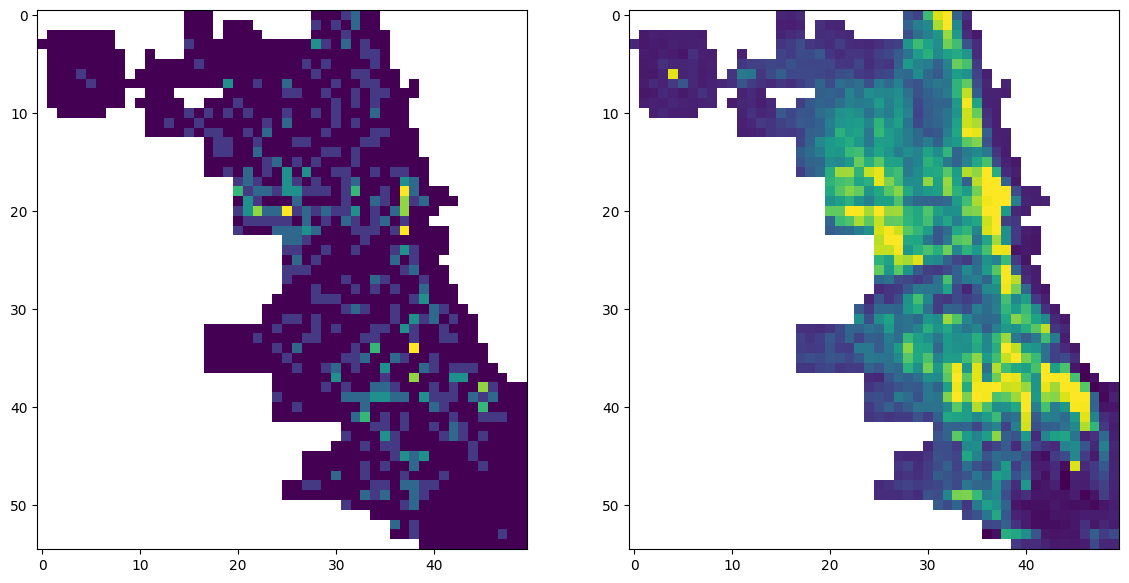

In [63]:
test_X_crimes_only[-1][mask == False] = np.nan

last_day_truth = test_X_crimes_only[-1]
last_day_pred = test_pred[-1]
last_day_pred[mask == False] = np.nan

fig, axs = plt.subplots(1, 2)
fig.set_figheight(7)
fig.set_figwidth(14)
axs[0].imshow(last_day_truth)
axs[1].imshow(last_day_pred)
plt.show()

### Final Scores

In [66]:
ground_truth = test_X_crimes_only[7:]
mse = np.nanmean(np.square(np.subtract(ground_truth, test_pred)))
print(f'Hetero-ConvLSTM - MSE: {mse.mean():.3f}')
print(f'Hetero-ConvLSTM - RMSE: {np.sqrt(mse).mean():.3f}')

Hetero-ConvLSTM - MSE: 0.285
Hetero-ConvLSTM - RMSE: 0.534
